## Model:

\begin{array}{l l l l }
\max_{} &    \sum_{j \in J} \sum_{h\in H} \sum_{p \in P} v_{jp}x_{jhp}              &   &\qquad \text{Maximize covered demand} \\
 s.t. & \sum_{h = N+1}^{M} y_{h} \leq U & &\qquad  \text{Bound number of opened hubs}\\
& \sum_{h = 1}^{N} y_{h} = N &  &\qquad \text{Set the first N hubs to be open}\\
& \sum_{h = 1}^{M} x_{jhp} \leq 1 & \forall j \in J, p \in P & \qquad \text{Ensure Every ODpair travels via at most one hub}\\
& x_{jhp} \leq  y_{h}  &\forall j\in J, p \in P, h \in H & \qquad \text {An ODpairs can only travel via an opened hub}\\
& x_{jhp} = 0 &\forall j, h, p \in F & \qquad \text{All OD-pairs that are in the 'not allowed' set F are set to 0}\\
& x_{jhp}, y_h \in \{0,1\} & \forall j \in J, h \in H, p \in P & \qquad \text {Domain constraints}\\\end{array}


## Sets:
$$
\begin{align*}
    H &: \text{set of hub indexes, where $h = 1,...,N$ refers to all existing hubs and indexes $h = N+1,...,M$ corresponds to all potential hub locations.}&&&&&\\
    P &: \text{Index set of POIs.}&&&&&\\
    J &: \text{Index set of all junction roads.}&&&&&\\
    F &= \{j\in J, h\in H, p\in P  | c_{jp} + Δ < c_{jh} + b_{hp} \; \text{or} \; b_{hp} > T \; \text{or} \; d_{hp} < D \; \text{or} \; d_{jp}- d_{jh} < τ \}&&&&&
\end{align*}
$$

## Parameters:
$$
\begin{array}{l l l l}
    v_{jp} &: \text{Demand from POI $p$, coming from junction $j$} &\\
    c_{jp} &: \text{Car travel time from junction $j$ to POI $p$ (min)} & \\
    c_{jh} &: \text{Car travel time from junction $j$ to hub $h$ (min)} & \\
    b_{hp} &: \text{Bike travel time from hub $h$ to POI $p$ (min)} & \\
    d_{jp} &: \text{Distance from junction $j$ to POI $p$ (kilometers)} & \\
    d_{hp} &: \text{Distance from hub $h$ to POI $p$ (kilometers)} & \\
    T &: \text{Longest accepted bike travel time from a hub to a POI (min)} & \\
    N &: \text{Number of existing hub locations} & \\
    U &: \text{Maximum number of new hubs planned to be opened} & \\
    D &: \text{Minimum distance between a hub and a POI (kilometers)} & \\
    Δ &: \text{Maximum allowed extra travel time by bike from car travel time (min)} & \\
    τ &: \text{Distance separating a hub location from a POI (kilometers)} &
\end{array}
$$

## Variables:
$$
\begin{align*}
    & x_{jhp} = \begin{cases} 1 & \text{if hub $h$ is assigned to POI $p$ from junction $j$ } \text{and} \; c_{jp} + Δ > c_{jh} + b_{hp}, d_{jp} - d_{sh} >τ , b_{hp} < T \; \text{and} \; d_{hp}  > D \\0 & \text{if not}\end{cases} \\
    & y_{h} = \begin{cases} 1 & \text{if hub $h$ is opened} \\0 & \text{else}\end{cases}
\end{align*}
$$

##Import all Packages

In [56]:
import sys
import io
import folium
import folium.plugins
import os
!pip install pyomo
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


if 'google.colab' in sys.modules:
    !pip install pyomo >/dev/null 2>/dev/null
    !pip install highspy >/dev/null 2>/dev/null

    from pyomo.contrib import appsi
    SOLVER = appsi.solvers.Highs(only_child_vars=False)

else:
    from pyomo.environ import SolverFactory
    SOLVER = SolverFactory('cbc')

assert SOLVER.available(), f"Solver {SOLVER} is not available."



##Optimization Model

In [57]:


##### Set working directory as that of the current file
# os.chdir(os.path.dirname(os.path.realpath(__file__)))


##### Loading the data
# 1) Loading the essential data for the model implementation
mobian_data = pd.read_excel("mobian_data.xlsx", sheet_name=None)
v = mobian_data["v"]
d_jh = mobian_data["d_jh"]
d_hp = mobian_data["d_hp"]
d_jp = mobian_data["d_jp"]
c_jh = mobian_data["c_jh"]
b_hp = mobian_data["b_hp"]
c_jp = mobian_data["c_jp"]
single_parameters = mobian_data["single_parameters"]

# 2) Loading extra sheets useful for visualizations & the report
junctions = mobian_data["junctions"]
hubs = mobian_data["hubs"]
pois = mobian_data["pois"]
ams_network_car = mobian_data["ams_network_car"]
ams_network_bike = mobian_data["ams_network_bike"]


##### Model implementation in Pyomo (Classical FLP)
m = pyo.ConcreteModel("Mobian Model Implementation")

# 1) Single parameters
T = single_parameters.at[0, "T"]
N = single_parameters.at[0, "N"]
U = single_parameters.at[0, "U"]
D = single_parameters.at[0, "D"]
Delta = single_parameters.at[0, "Delta"]
tau = single_parameters.at[0, "tau"]

# 2) Sets
F = []
for j in junctions.index:
    for h in hubs.index:
        for p in pois.index:
            if (c_jh.at[j, h] + b_hp.at[h, p] - c_jp.at[j, p] > Delta) or (b_hp.at[h, p] > T) or (d_hp.at[h, p] < D) or (d_jp.at[j, p] - d_jh.at[j, h] < tau):
               F.append(tuple([j, h, p]))

m.JUNCTIONS = pyo.Set(initialize=junctions.index)
m.HUBS = pyo.Set(initialize=hubs.index)
m.POIS = pyo.Set(initialize=pois.index)
m.F = pyo.Set(initialize=F)

# 3) Variables
m.x = pyo.Var(m.JUNCTIONS, m.HUBS, m.POIS, within=pyo.Binary)
m.y = pyo.Var(m.HUBS, within=pyo.Binary)

# 4) Objective function (maximize covered demand)
@m.Objective(sense=pyo.maximize)
def maximize_covered_demand(m):
    return pyo.quicksum(pyo.quicksum(pyo.quicksum(v.iloc[j,p] * m.x[j,h,p] for p in m.POIS) for h in m.HUBS) for j in m.JUNCTIONS)

# 5) Constraints

# 1st Constraint: Bound number of opened hubs (assuming no existing hubs)
@m.Constraint()
def max_hubs(m):
    return pyo.quicksum(m.y[h] for h in m.HUBS) <= U

# 2nd Constraint: Ensure every origin-destination pair travels via at most one hub
@m.Constraint(m.JUNCTIONS, m.POIS)
def use_at_most_one_hub(m, j, p):
    return pyo.quicksum(m.x[j,h,p] for h in m.HUBS) <= 1

# 3rd Constraint: An origin-destination pair can only use opened hubs
@m.Constraint(m.JUNCTIONS, m.HUBS, m.POIS)
def use_opened_hubs_only(m, j, h, p):
    return m.x[j,h,p] <= m.y[h]

# 4th Constraint: All origin-destination pairs that are in set F are set to 0
@m.Constraint(m.F)
def f_set(m, j, h, p):
    return m.x[j,h,p] == 0

# solver = pyo.SolverFactory("cbc")
SOLVER.solve(m)
pyo.value(m.maximize_covered_demand)

9587.154619899986

In [58]:
print("New Hub Locations:")
for h in m.HUBS:
    if pyo.value(m.y[h]) == 1:
        hub_name = hubs.loc[h]['Name']  # Get the hub's name from the DataFrame
        print(f'Hub {h} ({hub_name}) is opened.')


New Hub Locations:
Hub 6 (Mobihub Sloterdijk) is opened.
Hub 13 (Louwesweg) is opened.
Hub 48 (Parking55) is opened.
Hub 73 (Parking90) is opened.
Hub 107 (Parking134) is opened.
Hub 114 (Parking141) is opened.
Hub 156 (Qpark Oostpoort) is opened.


##Visualization of Demand Service per Hub

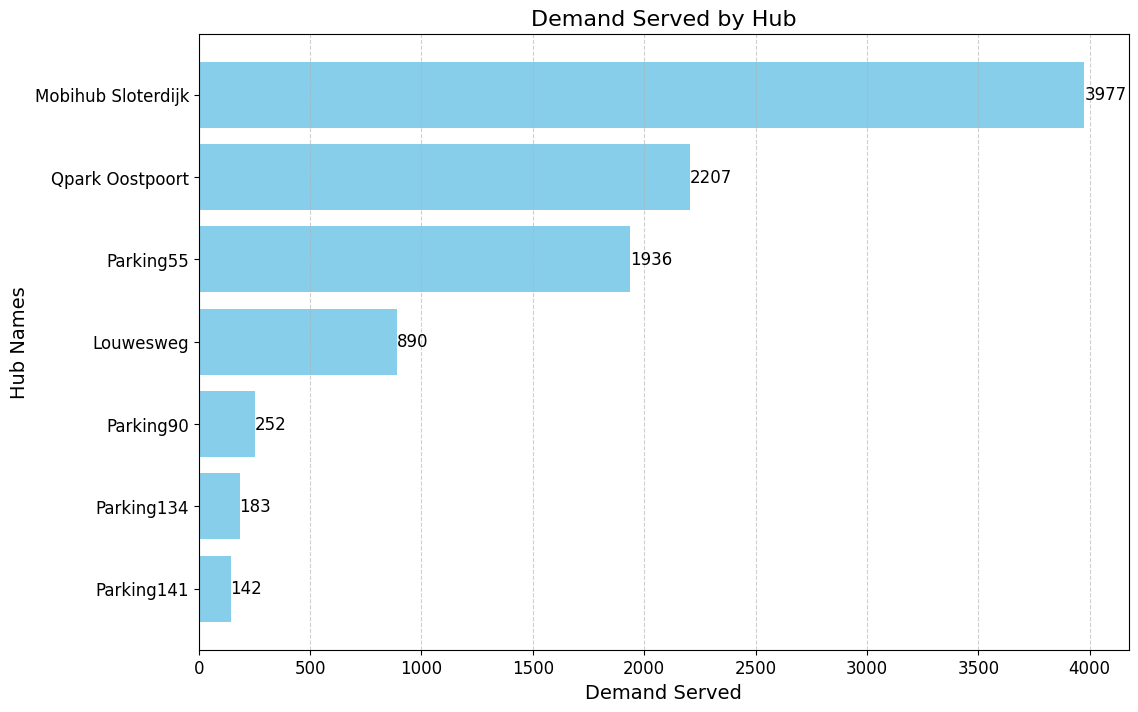

In [59]:
# Extract demand served by each hub
hub_demands = {}  # Initialize a dictionary to store hub name and its demand

for h in m.HUBS:
    if pyo.value(m.y[h]) == 1:
        hub_name = hubs.loc[h]['Name']
        hub_demands[hub_name] = sum(v.iloc[j, p] * pyo.value(m.x[j, h, p]) for j in m.JUNCTIONS for p in m.POIS)


# Sort hubs by demand in descending order
sorted_hubs = sorted(hub_demands.keys(), key=lambda x: hub_demands[x], reverse=True)
sorted_demands = [hub_demands[hub] for hub in sorted_hubs]

# Create a prettier bar chart
plt.figure(figsize=(12, 8))
plt.barh(sorted_hubs, sorted_demands, color='skyblue')
plt.xlabel("Demand Served", fontsize=14)
plt.ylabel("Hub Names", fontsize=14)
plt.title("Demand Served by Hub", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate the bars with the demand values
for i, demand in enumerate(sorted_demands):
    plt.text(demand, i, f"{demand:.0f}", va='center', fontsize=12)

plt.show()


##Visualization of All Hubs Locations on Map

In [60]:


# Create a list to store the coordinates and names of opened hubs
opened_hubs_data = []

# Iterate through hub indices to get their coordinates and names
for h in m.HUBS:
    if pyo.value(m.y[h]) == 1:
        hub_info = hubs.loc[h]
        lat = hub_info['Latitude']
        lon = hub_info['Longitude']
        name = hub_info['Name']

        opened_hubs_data.append((lat, lon, h, name))

# Create a Folium map
map = folium.Map(location=[52.5200, 13.4050], tiles="Stamen Terrain", zoom_start=10)

# Define custom marker colors
marker_colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkred', 'cadetblue', 'pink', 'white','black']

# Create a legend HTML using hub names
legend_html = """
    <div style="position: fixed; bottom: 160px; left: 80px; z-index: 9999; font-size: 22px;">
    <p><strong>Legend</strong></p>
    """

# Add markers for opened hubs
for index, (lat, lon, h, name) in enumerate(opened_hubs_data):
    color = marker_colors[index % len(marker_colors)]


    # Add the hub name to the legend
    legend_html += f'<p><i class="fa fa-circle fa-1x" style="color:{color}"></i> {name}</p>'

    # Create a marker with a custom icon and label
    marker = folium.Marker(
        location=[lat, lon],
        icon=folium.plugins.BeautifyIcon(
            icon_shape='marker',
            background_color=color,
            border_width=0,
            number=str(h),
            inner_icon_style='font-size:15px; text-align:center'
        ),
        popup=name
    )

    # Add the marker to the map
    marker.add_to(map)

# Close the legend HTML div ta
legend_html += "</div>"

# Add the legend to the map
legend = folium.Element(legend_html)
map.get_root().html.add_child(legend)

# Save the map to an HTML file or display it
map.save('opened_hubs_map_with_legend.html')
map



##Sensitivity / What-if Analysis on U

> Indented block



In [61]:
#Change U to test the change in demand coverage.

##### Loading the data
# 1) Loading the essential data for the model implementation
mobian_data = pd.read_excel("mobian_data.xlsx", sheet_name=None)
v = mobian_data["v"]
d_jh = mobian_data["d_jh"]
d_hp = mobian_data["d_hp"]
d_jp = mobian_data["d_jp"]
c_jh = mobian_data["c_jh"]
b_hp = mobian_data["b_hp"]
c_jp = mobian_data["c_jp"]
single_parameters = mobian_data["single_parameters"]

# 2) Loading extra sheets useful for visualizations & the report
junctions = mobian_data["junctions"]
hubs = mobian_data["hubs"]
pois = mobian_data["pois"]
ams_network_car = mobian_data["ams_network_car"]
ams_network_bike = mobian_data["ams_network_bike"]

# Lists to store U values and covered demands
U_values = []
average_covered_demands = []
maximum_coverages = []

##### Model implementation in Pyomo (Classical FLP)
for U_value in range(1, 16):  # Iterate through U values from 1 to 15
    m = pyo.ConcreteModel(f"Mobian Model Implementation with U={U_value}")


    # 1) Single parameters
    T = single_parameters.at[0, "T"]
    N = single_parameters.at[0, "N"]
    U = U_value
    D = single_parameters.at[0, "D"]
    Delta = single_parameters.at[0, "Delta"]
    tau = single_parameters.at[0, "tau"]

    # 2) Sets
    F = []
    for j in junctions.index:
        for h in hubs.index:
            for p in pois.index:
                if (c_jh.at[j, h] + b_hp.at[h, p] - c_jp.at[j, p] > Delta) or (b_hp.at[h, p] > T) or (d_hp.at[h, p] < D) or (d_jp.at[j, p] - d_jh.at[j, h] < tau):
                  F.append(tuple([j, h, p]))

    m.JUNCTIONS = pyo.Set(initialize=junctions.index)
    m.HUBS = pyo.Set(initialize=hubs.index)
    m.POIS = pyo.Set(initialize=pois.index)
    m.F = pyo.Set(initialize=F)

    # 3) Variables
    m.x = pyo.Var(m.JUNCTIONS, m.HUBS, m.POIS, within=pyo.Binary)
    m.y = pyo.Var(m.HUBS, within=pyo.Binary)

    # 4) Objective function (maximize covered demand)
    @m.Objective(sense=pyo.maximize)
    def maximize_covered_demand(m):
        return pyo.quicksum(pyo.quicksum(pyo.quicksum(v.iloc[j,p] * m.x[j,h,p] for p in m.POIS) for h in m.HUBS) for j in m.JUNCTIONS)

    # 5) Constraints

    # 1st Constraint: Bound number of opened hubs (assuming no existing hubs)
    @m.Constraint()
    def max_hubs(m):
        return pyo.quicksum(m.y[h] for h in m.HUBS) <= U

    # 2nd Constraint: Ensure every origin-destination pair travels via at most one hub
    @m.Constraint(m.JUNCTIONS, m.POIS)
    def use_at_most_one_hub(m, j, p):
        return pyo.quicksum(m.x[j,h,p] for h in m.HUBS) <= 1

    # 3rd Constraint: An origin-destination pair can only use opened hubs
    @m.Constraint(m.JUNCTIONS, m.HUBS, m.POIS)
    def use_opened_hubs_only(m, j, h, p):
        return m.x[j,h,p] <= m.y[h]

    # 4th Constraint: All origin-destination pairs that are in set F are set to 0
    @m.Constraint(m.F)
    def f_set(m, j, h, p):
        return m.x[j,h,p] == 0


    # solver = pyo.SolverFactory("cbc")
    SOLVER.solve(m)
    pyo.value(m.maximize_covered_demand)


  # Calculate the average demand covered per hub
    covered_demand = pyo.value(m.maximize_covered_demand)
    average_covered_demand = covered_demand / U_value  # Calculate average per hub
    U_values.append(U_value)
    average_covered_demands.append(average_covered_demand)

    # Calculate the maximum coverage
    maximum_coverage = pyo.value(m.maximize_covered_demand)
    maximum_coverages.append(maximum_coverage)
    print(f"U = {U_value}, Average Covered Demand per Hub: {average_covered_demand:.2f}, Maximum Coverage: {maximum_coverage:.2f}")



U = 1, Average Covered Demand per Hub: 6597.22, Maximum Coverage: 6597.22
U = 2, Average Covered Demand per Hub: 4148.62, Maximum Coverage: 8297.23
U = 3, Average Covered Demand per Hub: 2930.95, Maximum Coverage: 8792.84
U = 4, Average Covered Demand per Hub: 2294.26, Maximum Coverage: 9177.05
U = 5, Average Covered Demand per Hub: 1880.95, Maximum Coverage: 9404.73
U = 6, Average Covered Demand per Hub: 1588.95, Maximum Coverage: 9533.72
U = 7, Average Covered Demand per Hub: 1369.59, Maximum Coverage: 9587.15
U = 8, Average Covered Demand per Hub: 1200.53, Maximum Coverage: 9604.24
U = 9, Average Covered Demand per Hub: 1068.91, Maximum Coverage: 9620.16
U = 10, Average Covered Demand per Hub: 963.28, Maximum Coverage: 9632.76
U = 11, Average Covered Demand per Hub: 875.71, Maximum Coverage: 9632.76
U = 12, Average Covered Demand per Hub: 802.73, Maximum Coverage: 9632.76
U = 13, Average Covered Demand per Hub: 740.98, Maximum Coverage: 9632.76
U = 14, Average Covered Demand per Hub

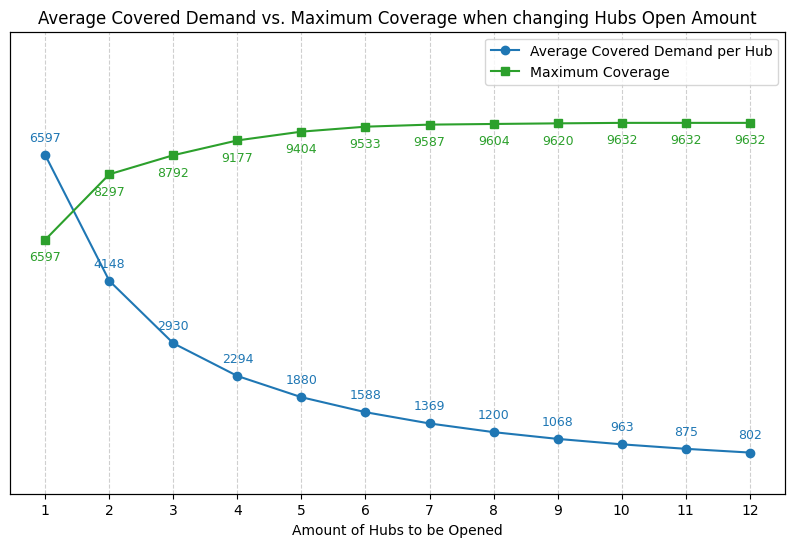

In [62]:
# Assuming U_values, average_covered_demands, and maximum_coverages lists have values beyond index 11 (0-based index),
# we'll slice the lists to only include values up to index 11.
U_values_12 = U_values[:12]
average_covered_demands_12 = average_covered_demands[:12]
maximum_coverages_12 = maximum_coverages[:12]

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the average covered demand on the left y-axis
ax1.plot(U_values_12, average_covered_demands_12, marker='o', linestyle='-', color='tab:blue', label='Average Covered Demand per Hub')
ax1.set_xlabel("Amount of Hubs to be Opened")
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Annotate data labels for the left y-axis with integers (no decimals)
for i, txt in enumerate(average_covered_demands_12):
    ax1.annotate(f"{int(txt)}", (U_values_12[i], txt), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='tab:blue')

# Create a second y-axis on the right for maximum coverage
ax2 = ax1.twinx()
ax2.plot(U_values_12, maximum_coverages_12, marker='s', linestyle='-', color='tab:green', label='Maximum Coverage')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Annotate data labels for the right y-axis with integers (no decimals)
for i, txt in enumerate(maximum_coverages_12):
    ax2.annotate(f"{int(txt)}", (U_values_12[i], txt), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9, color='tab:green')

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

# Customize the upper limits of both y-axes
ax1.set_ylim(1, 9000)
ax2.set_ylim(1, 12000)

# Set x-axis ticks to be integers from 1 to 12
ax1.set_xticks(list(range(1, 13)))

# Remove y-axis labels entirely
ax1.set_ylabel('')
ax2.set_ylabel('')

# Remove y-axis ticks (numbers) entirely
ax1.set_yticks([])
ax2.set_yticks([])

# Hide y-axis label names
ax1.yaxis.label.set_visible(False)
ax2.yaxis.label.set_visible(False)

plt.title("Average Covered Demand vs. Maximum Coverage when changing Hubs Open Amount")

# Show the plot
plt.show()


In [63]:
#Knowing that U=10 is optimal value of U


##### Loading the data
# 1) Loading the essential data for the model implementation
mobian_data = pd.read_excel("mobian_data.xlsx", sheet_name=None)
v = mobian_data["v"]
d_jh = mobian_data["d_jh"]
d_hp = mobian_data["d_hp"]
d_jp = mobian_data["d_jp"]
c_jh = mobian_data["c_jh"]
b_hp = mobian_data["b_hp"]
c_jp = mobian_data["c_jp"]
single_parameters = mobian_data["single_parameters"]

# 2) Loading extra sheets useful for visualizations & the report
junctions = mobian_data["junctions"]
hubs = mobian_data["hubs"]
pois = mobian_data["pois"]
ams_network_car = mobian_data["ams_network_car"]
ams_network_bike = mobian_data["ams_network_bike"]


##### Model implementation in Pyomo (Classical FLP)
m = pyo.ConcreteModel("Mobian Model Implementation")

# 1) Single parameters
T = single_parameters.at[0, "T"]
N = single_parameters.at[0, "N"]
U = 10
D = single_parameters.at[0, "D"]
Delta = single_parameters.at[0, "Delta"]
tau = single_parameters.at[0, "tau"]

# 2) Sets
F = []
for j in junctions.index:
    for h in hubs.index:
        for p in pois.index:
            if (c_jh.at[j, h] + b_hp.at[h, p] - c_jp.at[j, p] > Delta) or (b_hp.at[h, p] > T) or (d_hp.at[h, p] < D) or (d_jp.at[j, p] - d_jh.at[j, h] < tau):
               F.append(tuple([j, h, p]))

m.JUNCTIONS = pyo.Set(initialize=junctions.index)
m.HUBS = pyo.Set(initialize=hubs.index)
m.POIS = pyo.Set(initialize=pois.index)
m.F = pyo.Set(initialize=F)

# 3) Variables
m.x = pyo.Var(m.JUNCTIONS, m.HUBS, m.POIS, within=pyo.Binary)
m.y = pyo.Var(m.HUBS, within=pyo.Binary)

# 4) Objective function (maximize covered demand)
@m.Objective(sense=pyo.maximize)
def maximize_covered_demand(m):
    return pyo.quicksum(pyo.quicksum(pyo.quicksum(v.iloc[j,p] * m.x[j,h,p] for p in m.POIS) for h in m.HUBS) for j in m.JUNCTIONS)

# 5) Constraints

# 1st Constraint: Bound number of opened hubs (assuming no existing hubs)
@m.Constraint()
def max_hubs(m):
    return pyo.quicksum(m.y[h] for h in m.HUBS) <= U

# 2nd Constraint: Ensure every origin-destination pair travels via at most one hub
@m.Constraint(m.JUNCTIONS, m.POIS)
def use_at_most_one_hub(m, j, p):
    return pyo.quicksum(m.x[j,h,p] for h in m.HUBS) <= 1

# 3rd Constraint: An origin-destination pair can only use opened hubs
@m.Constraint(m.JUNCTIONS, m.HUBS, m.POIS)
def use_opened_hubs_only(m, j, h, p):
    return m.x[j,h,p] <= m.y[h]

# 4th Constraint: All origin-destination pairs that are in set F are set to 0
@m.Constraint(m.F)
def f_set(m, j, h, p):
    return m.x[j,h,p] == 0

# solver = pyo.SolverFactory("cbc")
SOLVER.solve(m)
pyo.value(m.maximize_covered_demand)

9632.761269099987

In [64]:
print("New Hub Locations:")
for h in m.HUBS:
    if pyo.value(m.y[h]) == 1:
        hub_name = hubs.loc[h]['Name']
        print(f'Hub {h} ({hub_name}).')


New Hub Locations:
Hub 6 (Mobihub Sloterdijk).
Hub 46 (Parking52).
Hub 48 (Parking55).
Hub 62 (Fleerde pakeerplaats).
Hub 73 (Parking90).
Hub 107 (Parking134).
Hub 114 (Parking141).
Hub 132 (Willemspoort).
Hub 139 (Prins en Keizer).
Hub 156 (Qpark Oostpoort).


In [69]:
# Create a list to store the coordinates and names of opened hubs
opened_optimal_hubs_data = []

# Iterate through hub indices to get their coordinates and names
for h in m.HUBS:
    if pyo.value(m.y[h]) == 1:
        hub_info = hubs.loc[h]
        lat = hub_info['Latitude']
        lon = hub_info['Longitude']
        name = hub_info['Name']

        opened_optimal_hubs_data.append((lat, lon, name))

# Create a Folium map
optimal_map = folium.Map(location=[52.5200, 13.4050], tiles="Stamen Terrain", zoom_start=10)

# Define custom marker colors
marker_colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkred', 'cadetblue', 'pink', 'olive','yellow']


# Create a legend HTML using hub names
legend_html = """
    <div style="position: fixed; bottom: 160px; left: 80px; z-index: 9999; font-size: 12px;">
    <p><strong>Legend</strong></p>
    """

# Add markers for opened hubs with custom icons and labels
for index, (lat, lon, name) in enumerate(opened_optimal_hubs_data):
    color = marker_colors[index % len(marker_colors)]

    # Add the hub name to the legend
    legend_html += f'<p><i class="fa fa-circle fa-1x" style="color:{color}"></i> {name}</p>'

    # Create a marker with a custom icon
    marker = folium.Marker(
        location=[lat, lon],
        icon=folium.plugins.BeautifyIcon(
            icon_shape='marker',
            background_color=color,
            border_width=0,
            inner_icon_style='font-size:15px; text-align:center'
        ),
        popup=name  # Use the hub name as the popup label
    )

    # Add the marker to the map
    marker.add_to(optimal_map)

# Close the legend HTML div tag
legend_html += "</div>"

# Add the legend to the map
legend = folium.Element(legend_html)
optimal_map.get_root().html.add_child(legend)

# Save the map to an HTML file or display it
optimal_map.save('opened_hubs_map_with_legend.html')
optimal_map





## Sensitivity Analysis on T


In [70]:
#Change U to test the change in demand coverage.

##### Loading the data
# 1) Loading the essential data for the model implementation
mobian_data = pd.read_excel("mobian_data.xlsx", sheet_name=None)
v = mobian_data["v"]
d_jh = mobian_data["d_jh"]
d_hp = mobian_data["d_hp"]
d_jp = mobian_data["d_jp"]
c_jh = mobian_data["c_jh"]
b_hp = mobian_data["b_hp"]
c_jp = mobian_data["c_jp"]
single_parameters = mobian_data["single_parameters"]

# 2) Loading extra sheets useful for visualizations & the report
junctions = mobian_data["junctions"]
hubs = mobian_data["hubs"]
pois = mobian_data["pois"]
ams_network_car = mobian_data["ams_network_car"]
ams_network_bike = mobian_data["ams_network_bike"]

# Lists to store U values and covered demands
T_values = []
average_covered_demand_T = []
maximum_coverages_T = []

##### Model implementation in Pyomo (Classical FLP)
for T_value in range(25,45):  # Iterate through T Values from 25 to 45
    m_T = pyo.ConcreteModel(f"Mobian Model Implementation with T={T_value}")


    # 1) Single parameters
    T = T_value
    N = single_parameters.at[0, "N"]
    U = single_parameters.at[0, "U"]
    D = single_parameters.at[0, "D"]
    Delta = single_parameters.at[0, "Delta"]
    tau = single_parameters.at[0, "tau"]

    # 2) Sets
    F = []
    for j in junctions.index:
        for h in hubs.index:
            for p in pois.index:
                if (c_jh.at[j, h] + b_hp.at[h, p] - c_jp.at[j, p] > Delta) or (b_hp.at[h, p] > T) or (d_hp.at[h, p] < D) or (d_jp.at[j, p] - d_jh.at[j, h] < tau):
                  F.append(tuple([j, h, p]))

    m_T.JUNCTIONS = pyo.Set(initialize=junctions.index)
    m_T.HUBS = pyo.Set(initialize=hubs.index)
    m_T.POIS = pyo.Set(initialize=pois.index)
    m_T.F = pyo.Set(initialize=F)

    # 3) Variables
    m_T.x = pyo.Var(m_T.JUNCTIONS, m_T.HUBS, m_T.POIS, within=pyo.Binary)
    m_T.y = pyo.Var(m_T.HUBS, within=pyo.Binary)

    # 4) Objective function (maximize covered demand)
    @m_T.Objective(sense=pyo.maximize)
    def maximize_covered_demand(m_T):
        return pyo.quicksum(pyo.quicksum(pyo.quicksum(v.iloc[j,p] * m_T.x[j,h,p] for p in m_T.POIS) for h in m_T.HUBS) for j in m_T.JUNCTIONS)

    # 5) Constraints

    # 1st Constraint: Bound number of opened hubs (assuming no existing hubs)
    @m_T.Constraint()
    def max_hubs(m_T):
        return pyo.quicksum(m_T.y[h] for h in m_T.HUBS) <= U

    # 2nd Constraint: Ensure every origin-destination pair travels via at most one hub
    @m_T.Constraint(m_T.JUNCTIONS, m_T.POIS)
    def use_at_most_one_hub(m_T, j, p):
        return pyo.quicksum(m_T.x[j,h,p] for h in m_T.HUBS) <= 1

    # 3rd Constraint: An origin-destination pair can only use opened hubs
    @m_T.Constraint(m_T.JUNCTIONS, m_T.HUBS, m_T.POIS)
    def use_opened_hubs_only(m_T, j, h, p):
        return m_T.x[j,h,p] <= m_T.y[h]

    # 4th Constraint: All origin-destination pairs that are in set F are set to 0
    @m_T.Constraint(m_T.F)
    def f_set(m_T, j, h, p):
        return m_T.x[j,h,p] == 0


    # solver = pyo.SolverFactory("cbc")
    SOLVER.solve(m_T)
    pyo.value(m_T.maximize_covered_demand)


  # Calculate the average demand covered per hub
    covered_demand = pyo.value(m_T.maximize_covered_demand)
    average_covered_demand_for_current_T = covered_demand / U
    average_covered_demand_T.append(average_covered_demand_for_current_T)


    # Calculate the maximum coverage
    maximum_coverage = pyo.value(m_T.maximize_covered_demand)
    maximum_coverages_T.append(maximum_coverage)

    T_values.append(T_value)  # Storing the T_value for each iteration

    print(f"T = {T_value}, average_covered_demand_for_current_T: {average_covered_demand_for_current_T:.2f}, Maximum Coverage: {maximum_coverage:.2f}")



T = 25, average_covered_demand_for_current_T: 1367.19, Maximum Coverage: 9570.31
T = 26, average_covered_demand_for_current_T: 1367.19, Maximum Coverage: 9570.31
T = 27, average_covered_demand_for_current_T: 1369.59, Maximum Coverage: 9587.15
T = 28, average_covered_demand_for_current_T: 1369.59, Maximum Coverage: 9587.15
T = 29, average_covered_demand_for_current_T: 1369.59, Maximum Coverage: 9587.15
T = 30, average_covered_demand_for_current_T: 1369.59, Maximum Coverage: 9587.15
T = 31, average_covered_demand_for_current_T: 1369.59, Maximum Coverage: 9587.15
T = 32, average_covered_demand_for_current_T: 1369.59, Maximum Coverage: 9587.15
T = 33, average_covered_demand_for_current_T: 1369.59, Maximum Coverage: 9587.15
T = 34, average_covered_demand_for_current_T: 1369.59, Maximum Coverage: 9587.15
T = 35, average_covered_demand_for_current_T: 1369.59, Maximum Coverage: 9587.15
T = 36, average_covered_demand_for_current_T: 1369.59, Maximum Coverage: 9587.15
T = 37, average_covered_dema

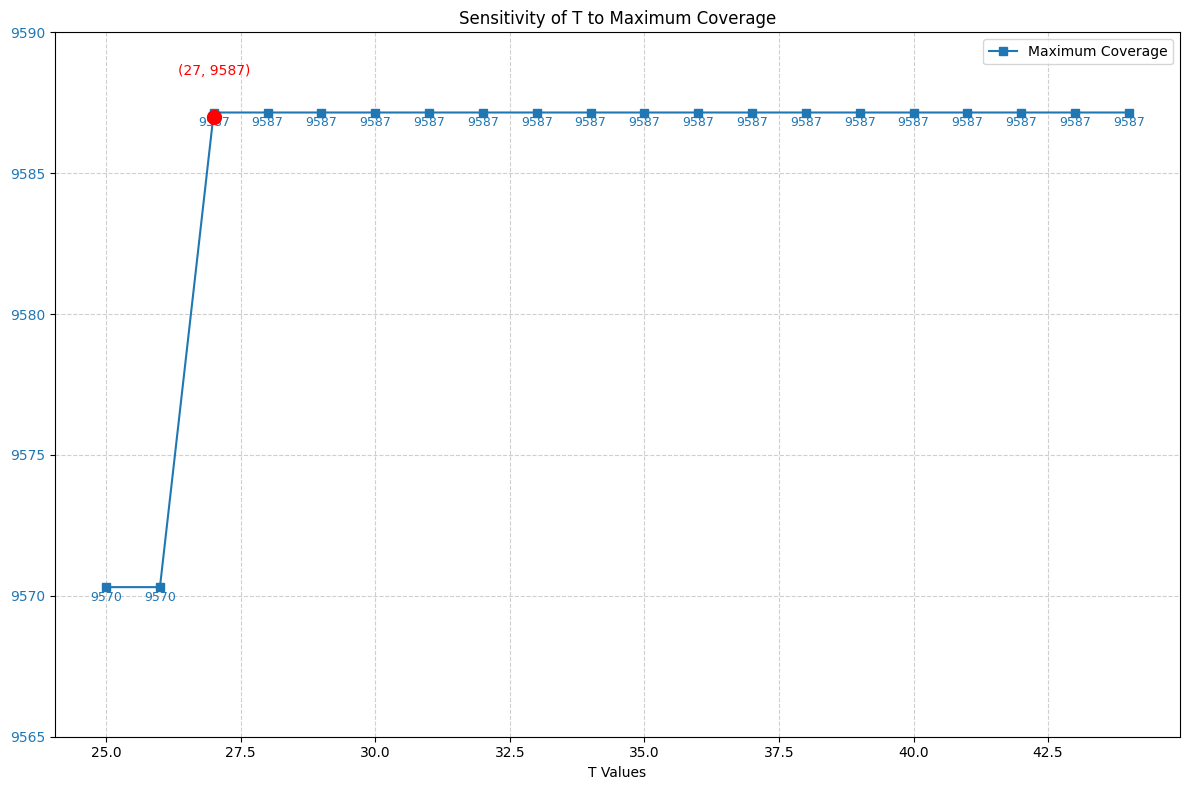

In [71]:

T_values_range = T_values
maximum_coverages_T_range = maximum_coverages_T

fig, ax = plt.subplots(figsize=(12, 8))


ax.plot(T_values_range, maximum_coverages_T_range, marker='s', linestyle='-', color='tab:blue', label='Maximum Coverage')
ax.set_xlabel("T Values")
ax.tick_params(axis='y', labelcolor='tab:blue')
ax.grid(True, linestyle='--', alpha=0.6)

for i, txt in enumerate(maximum_coverages_T_range):
    ax.annotate(f"{int(txt)}", (T_values_range[i], txt), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=9, color='tab:blue')

highlighted_value = 9587
highlighted_point = (27, highlighted_value)
ax.scatter(*highlighted_point, color='red', s=100, zorder=5)
ax.annotate(f"{highlighted_point}", (highlighted_point[0], highlighted_point[1] + 1), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='red', zorder=5)



ax.legend(loc='best')

ax.set_ylim(9565, 9590)


plt.title("Sensitivity of T to Maximum Coverage")


plt.tight_layout()
plt.show()


##When U = 3

In [79]:


##### Set working directory as that of the current file
# os.chdir(os.path.dirname(os.path.realpath(__file__)))


##### Loading the data
# 1) Loading the essential data for the model implementation
mobian_data = pd.read_excel("mobian_data.xlsx", sheet_name=None)
v = mobian_data["v"]
d_jh = mobian_data["d_jh"]
d_hp = mobian_data["d_hp"]
d_jp = mobian_data["d_jp"]
c_jh = mobian_data["c_jh"]
b_hp = mobian_data["b_hp"]
c_jp = mobian_data["c_jp"]
single_parameters = mobian_data["single_parameters"]

# 2) Loading extra sheets useful for visualizations & the report
junctions = mobian_data["junctions"]
hubs = mobian_data["hubs"]
pois = mobian_data["pois"]
ams_network_car = mobian_data["ams_network_car"]
ams_network_bike = mobian_data["ams_network_bike"]


##### Model implementation in Pyomo (Classical FLP)
m = pyo.ConcreteModel("Mobian Model Implementation")

# 1) Single parameters
T = single_parameters.at[0, "T"]
N = single_parameters.at[0, "N"]
U = 3
D = single_parameters.at[0, "D"]
Delta = single_parameters.at[0, "Delta"]
tau = single_parameters.at[0, "tau"]

# 2) Sets
F = []
for j in junctions.index:
    for h in hubs.index:
        for p in pois.index:
            if (c_jh.at[j, h] + b_hp.at[h, p] - c_jp.at[j, p] > Delta) or (b_hp.at[h, p] > T) or (d_hp.at[h, p] < D) or (d_jp.at[j, p] - d_jh.at[j, h] < tau):
               F.append(tuple([j, h, p]))

m.JUNCTIONS = pyo.Set(initialize=junctions.index)
m.HUBS = pyo.Set(initialize=hubs.index)
m.POIS = pyo.Set(initialize=pois.index)
m.F = pyo.Set(initialize=F)

# 3) Variables
m.x = pyo.Var(m.JUNCTIONS, m.HUBS, m.POIS, within=pyo.Binary)
m.y = pyo.Var(m.HUBS, within=pyo.Binary)

# 4) Objective function (maximize covered demand)
@m.Objective(sense=pyo.maximize)
def maximize_covered_demand(m):
    return pyo.quicksum(pyo.quicksum(pyo.quicksum(v.iloc[j,p] * m.x[j,h,p] for p in m.POIS) for h in m.HUBS) for j in m.JUNCTIONS)

# 5) Constraints

# 1st Constraint: Bound number of opened hubs (assuming no existing hubs)
@m.Constraint()
def max_hubs(m):
    return pyo.quicksum(m.y[h] for h in m.HUBS) <= U

# 2nd Constraint: Ensure every origin-destination pair travels via at most one hub
@m.Constraint(m.JUNCTIONS, m.POIS)
def use_at_most_one_hub(m, j, p):
    return pyo.quicksum(m.x[j,h,p] for h in m.HUBS) <= 1

# 3rd Constraint: An origin-destination pair can only use opened hubs
@m.Constraint(m.JUNCTIONS, m.HUBS, m.POIS)
def use_opened_hubs_only(m, j, h, p):
    return m.x[j,h,p] <= m.y[h]

# 4th Constraint: All origin-destination pairs that are in set F are set to 0
@m.Constraint(m.F)
def f_set(m, j, h, p):
    return m.x[j,h,p] == 0

# solver = pyo.SolverFactory("cbc")
SOLVER.solve(m)
pyo.value(m.maximize_covered_demand)


8792.84458269999

In [80]:
print("New Hub Locations:")
for h in m.HUBS:
    if pyo.value(m.y[h]) == 1:
        hub_name = hubs.loc[h]['Name']
        print(f'Hub {h} ({hub_name}).')

New Hub Locations:
Hub 6 (Mobihub Sloterdijk).
Hub 13 (Louwesweg).
Hub 145 (Weesperplein).


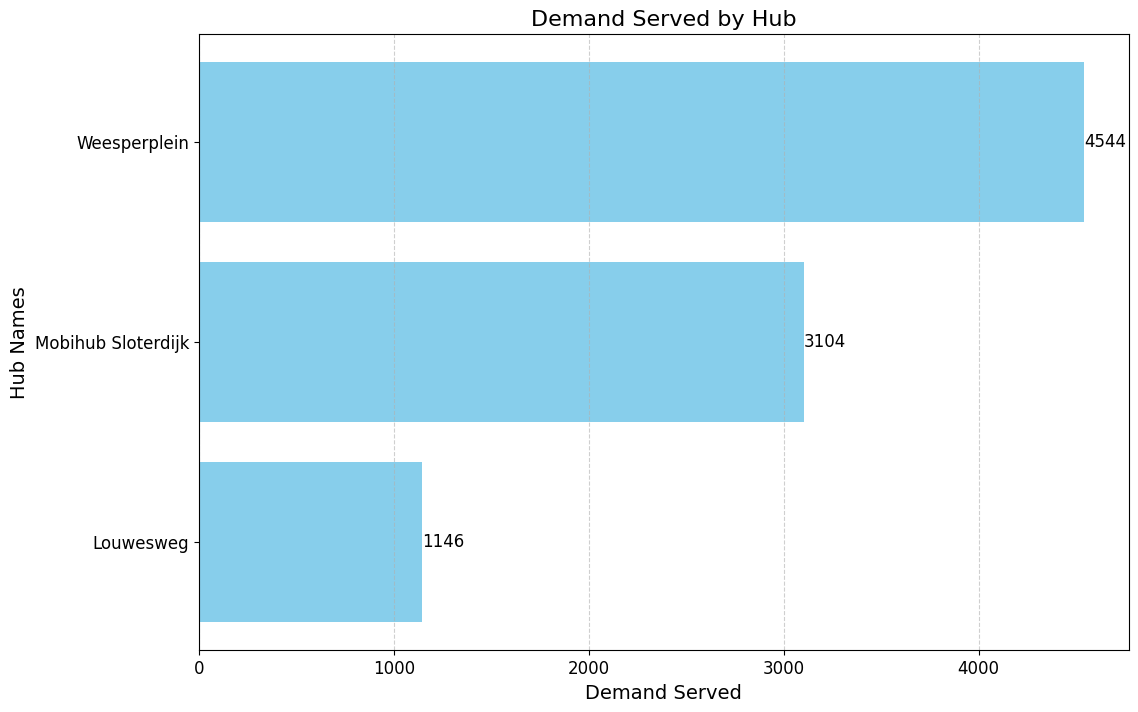

In [81]:
# Extract demand served by each hub
hub_demands = {}

for h in m.HUBS:
    if pyo.value(m.y[h]) == 1:
        hub_name = hubs.loc[h]['Name']
        hub_demands[hub_name] = sum(v.iloc[j, p] * pyo.value(m.x[j, h, p]) for j in m.JUNCTIONS for p in m.POIS)


# Sort hubs by demand in descending order
sorted_hubs = sorted(hub_demands.keys(), key=lambda x: hub_demands[x], reverse=True)
sorted_demands = [hub_demands[hub] for hub in sorted_hubs]

# Create a prettier bar chart
plt.figure(figsize=(12, 8))
plt.barh(sorted_hubs, sorted_demands, color='skyblue')
plt.xlabel("Demand Served", fontsize=14)
plt.ylabel("Hub Names", fontsize=14)
plt.title("Demand Served by Hub", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate the bars with the demand values
for i, demand in enumerate(sorted_demands):
    plt.text(demand, i, f"{demand:.0f}", va='center', fontsize=12)

plt.show()


In [82]:


# Create a list to store the coordinates and names of opened hubs
opened_hubs_data = []

# Iterate through hub indices to get their coordinates and names
for h in m.HUBS:
    if pyo.value(m.y[h]) == 1:
        hub_info = hubs.loc[h]
        lat = hub_info['Latitude']
        lon = hub_info['Longitude']
        name = hub_info['Name']

        opened_hubs_data.append((lat, lon, h, name))

# Create a Folium map
map = folium.Map(location=[52.5200, 13.4050], tiles="Stamen Terrain", zoom_start=10)

# Define custom marker colors
marker_colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkred', 'cadetblue', 'pink', 'white','black']

# Create a legend HTML using hub names
legend_html = """
    <div style="position: fixed; bottom: 160px; left: 80px; z-index: 9999; font-size: 22px;">
    <p><strong>Legend</strong></p>
    """

# Add markers for opened hubs with custom icons and labels
for index, (lat, lon, h, name) in enumerate(opened_hubs_data):
    color = marker_colors[index % len(marker_colors)]

    # Add the hub name to the legend
    legend_html += f'<p><i class="fa fa-circle fa-1x" style="color:{color}"></i> {name}</p>'

    # Create a marker with a custom icon and label
    marker = folium.Marker(
        location=[lat, lon],
        icon=folium.plugins.BeautifyIcon(
            icon_shape='marker',
            background_color=color,
            border_width=0,
            number=str(h),
            inner_icon_style='font-size:15px; text-align:center'
        ),
        popup=name  # Use the hub name as the popup label
    )

    # Add the marker to the map
    marker.add_to(map)

# Close the legend HTML div tag
legend_html += "</div>"

# Add the legend to the map
legend = folium.Element(legend_html)
map.get_root().html.add_child(legend)

# Save the map to an HTML file or display it
map.save('opened_hubs_map_with_legend.html')
map



##When U = 4

In [75]:


##### Set working directory as that of the current file
# os.chdir(os.path.dirname(os.path.realpath(__file__)))


##### Loading the data
# 1) Loading the essential data for the model implementation
mobian_data = pd.read_excel("mobian_data.xlsx", sheet_name=None)
v = mobian_data["v"]
d_jh = mobian_data["d_jh"]
d_hp = mobian_data["d_hp"]
d_jp = mobian_data["d_jp"]
c_jh = mobian_data["c_jh"]
b_hp = mobian_data["b_hp"]
c_jp = mobian_data["c_jp"]
single_parameters = mobian_data["single_parameters"]

# 2) Loading extra sheets useful for visualizations & the report
junctions = mobian_data["junctions"]
hubs = mobian_data["hubs"]
pois = mobian_data["pois"]
ams_network_car = mobian_data["ams_network_car"]
ams_network_bike = mobian_data["ams_network_bike"]


##### Model implementation in Pyomo (Classical FLP)
m = pyo.ConcreteModel("Mobian Model Implementation")

# 1) Single parameters
T = single_parameters.at[0, "T"]
N = single_parameters.at[0, "N"]
U = 4
D = single_parameters.at[0, "D"]
Delta = single_parameters.at[0, "Delta"]
tau = single_parameters.at[0, "tau"]

# 2) Sets
F = []
for j in junctions.index:
    for h in hubs.index:
        for p in pois.index:
            if (c_jh.at[j, h] + b_hp.at[h, p] - c_jp.at[j, p] > Delta) or (b_hp.at[h, p] > T) or (d_hp.at[h, p] < D) or (d_jp.at[j, p] - d_jh.at[j, h] < tau):
               F.append(tuple([j, h, p]))

m.JUNCTIONS = pyo.Set(initialize=junctions.index)
m.HUBS = pyo.Set(initialize=hubs.index)
m.POIS = pyo.Set(initialize=pois.index)
m.F = pyo.Set(initialize=F)

# 3) Variables
m.x = pyo.Var(m.JUNCTIONS, m.HUBS, m.POIS, within=pyo.Binary)
m.y = pyo.Var(m.HUBS, within=pyo.Binary)

# 4) Objective function (maximize covered demand)
@m.Objective(sense=pyo.maximize)
def maximize_covered_demand(m):
    return pyo.quicksum(pyo.quicksum(pyo.quicksum(v.iloc[j,p] * m.x[j,h,p] for p in m.POIS) for h in m.HUBS) for j in m.JUNCTIONS)

# 5) Constraints

# 1st Constraint: Bound number of opened hubs (assuming no existing hubs)
@m.Constraint()
def max_hubs(m):
    return pyo.quicksum(m.y[h] for h in m.HUBS) <= U

# 2nd Constraint: Ensure every origin-destination pair travels via at most one hub
@m.Constraint(m.JUNCTIONS, m.POIS)
def use_at_most_one_hub(m, j, p):
    return pyo.quicksum(m.x[j,h,p] for h in m.HUBS) <= 1

# 3rd Constraint: An origin-destination pair can only use opened hubs
@m.Constraint(m.JUNCTIONS, m.HUBS, m.POIS)
def use_opened_hubs_only(m, j, h, p):
    return m.x[j,h,p] <= m.y[h]

# 4th Constraint: All origin-destination pairs that are in set F are set to 0
@m.Constraint(m.F)
def f_set(m, j, h, p):
    return m.x[j,h,p] == 0

# solver = pyo.SolverFactory("cbc")
SOLVER.solve(m)
pyo.value(m.maximize_covered_demand)


9177.051801499993

In [76]:
print("New Hub Locations:")
for h in m.HUBS:
    if pyo.value(m.y[h]) == 1:
        hub_name = hubs.loc[h]['Name']
        print(f'Hub {h} ({hub_name}).')

New Hub Locations:
Hub 3 (Mobihub Oost).
Hub 6 (Mobihub Sloterdijk).
Hub 13 (Louwesweg).
Hub 48 (Parking55).


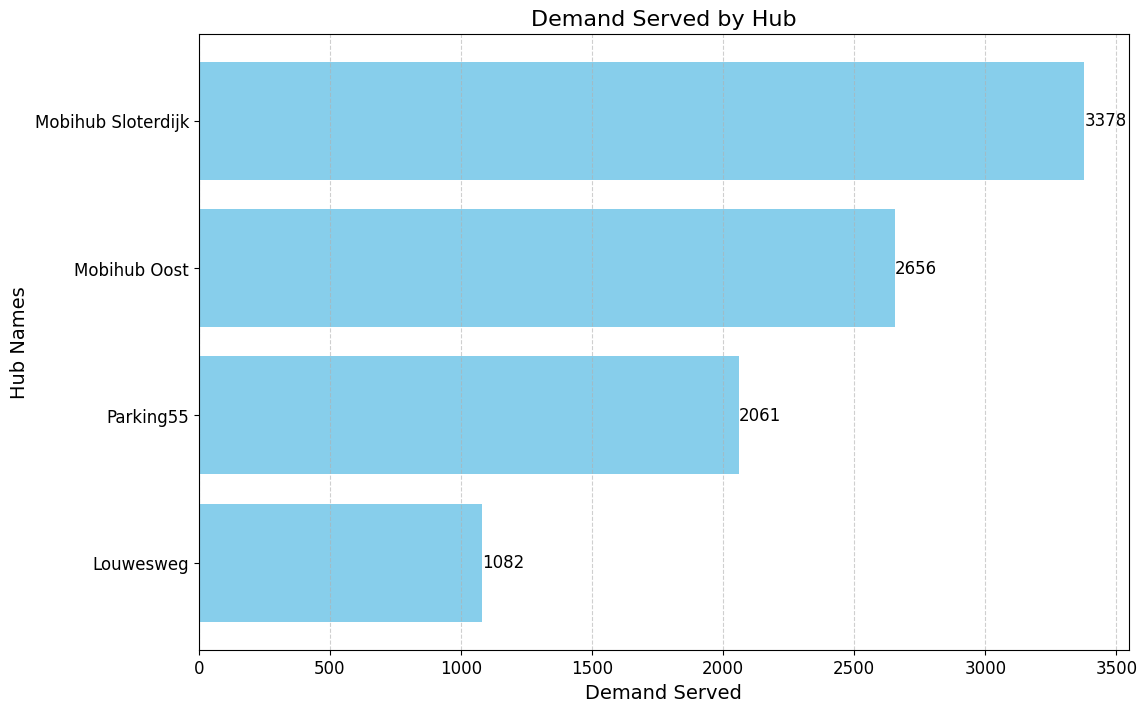

In [77]:
# Extract demand served by each hub
hub_demands = {}

for h in m.HUBS:
    if pyo.value(m.y[h]) == 1:
        hub_name = hubs.loc[h]['Name']
        hub_demands[hub_name] = sum(v.iloc[j, p] * pyo.value(m.x[j, h, p]) for j in m.JUNCTIONS for p in m.POIS)


# Sort hubs by demand in descending order
sorted_hubs = sorted(hub_demands.keys(), key=lambda x: hub_demands[x], reverse=True)
sorted_demands = [hub_demands[hub] for hub in sorted_hubs]

# Create a prettier bar chart
plt.figure(figsize=(12, 8))
plt.barh(sorted_hubs, sorted_demands, color='skyblue')
plt.xlabel("Demand Served", fontsize=14)
plt.ylabel("Hub Names", fontsize=14)
plt.title("Demand Served by Hub", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate the bars with the demand values
for i, demand in enumerate(sorted_demands):
    plt.text(demand, i, f"{demand:.0f}", va='center', fontsize=12)

plt.show()
